In [2]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [3]:
df_raw = pd.read_csv('data/co_ev_registrations_public.csv')

In [4]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2010-01-07,3.0
2010-01-12,1.0
2010-01-14,1.0
2010-01-20,1.0
2010-01-27,4.0
...,...
2022-07-07,229.0
2022-07-08,221.0
2022-07-09,113.0


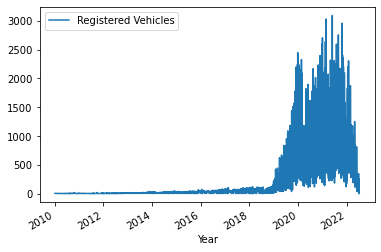

In [5]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [6]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [7]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

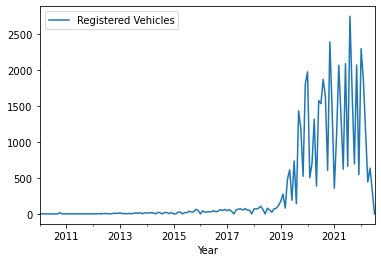

In [8]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [9]:
adtest = adfuller(df)
display(adtest)

(-2.049365086120689,
 0.2653561352166268,
 14,
 136,
 {'1%': -3.4793722137854926,
  '5%': -2.8830370378332995,
  '10%': -2.578233635380623},
 1956.193420640764)

## Modeling

In [17]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2018-06-30':'2021-12-31']
test = df['2022-01-31':]
combined = df

test

,Registered Vehicles
Year,
2022-01-31,2303.0
2022-02-28,1873.0
2022-03-31,1143.0
2022-04-30,445.0
2022-05-31,640.0
2022-06-30,315.0
2022-07-31,1.0


In [18]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=734.106, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=704.338, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=717.173, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=696.347, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=683.375, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=684.938, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=684.388, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=685.945, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=685.971, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=683.213, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=692.915, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=685.018, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=684.778, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=686.869, Time=0.15 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, 

### The best model is :  ARIMA (3, 0, 0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1258      0.139      0.904      0.366      -0.147       0.398
ar.L2          0.2486      0.121      2.059      0.040       0.012       0.485
ar.L3          0.5918      0.151      3.915      0.000       0.296       0.888
sigma2      3.937e+05   1.03e+05      3.825      0.000    1.92e+05    5.95e+05


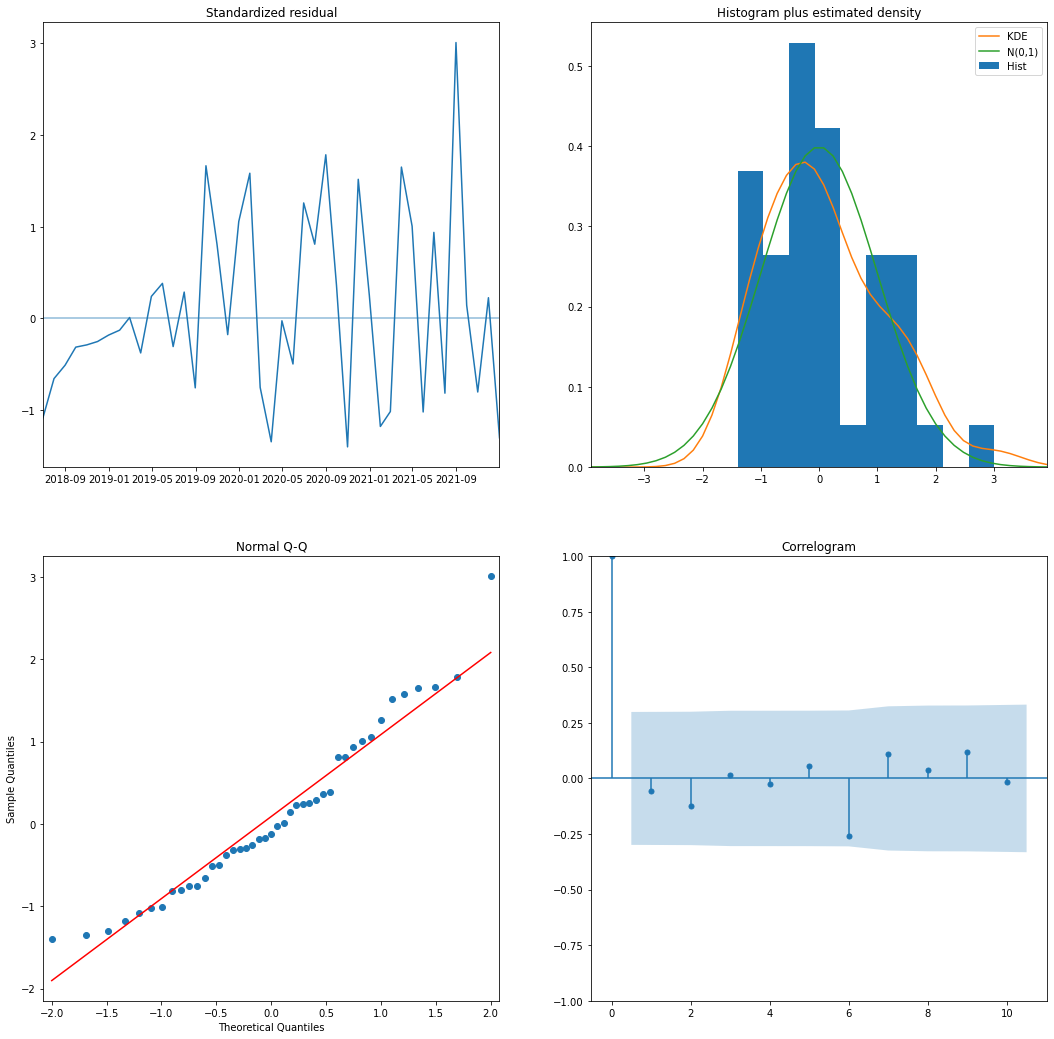

In [19]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(3,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [21]:
pred = output.get_prediction(start=pd.to_datetime('2022-01-31'), end=pd.to_datetime('2022-07-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2022-01-31,-232.770795,2226.815097
2022-02-28,249.836746,2728.794045
2022-03-31,-522.595584,2040.223414
2022-04-30,-458.775110,2570.045026
2022-05-31,-336.239257,2741.694969
2022-06-30,-734.533243,2459.921052
2022-07-31,-673.862852,2738.166819


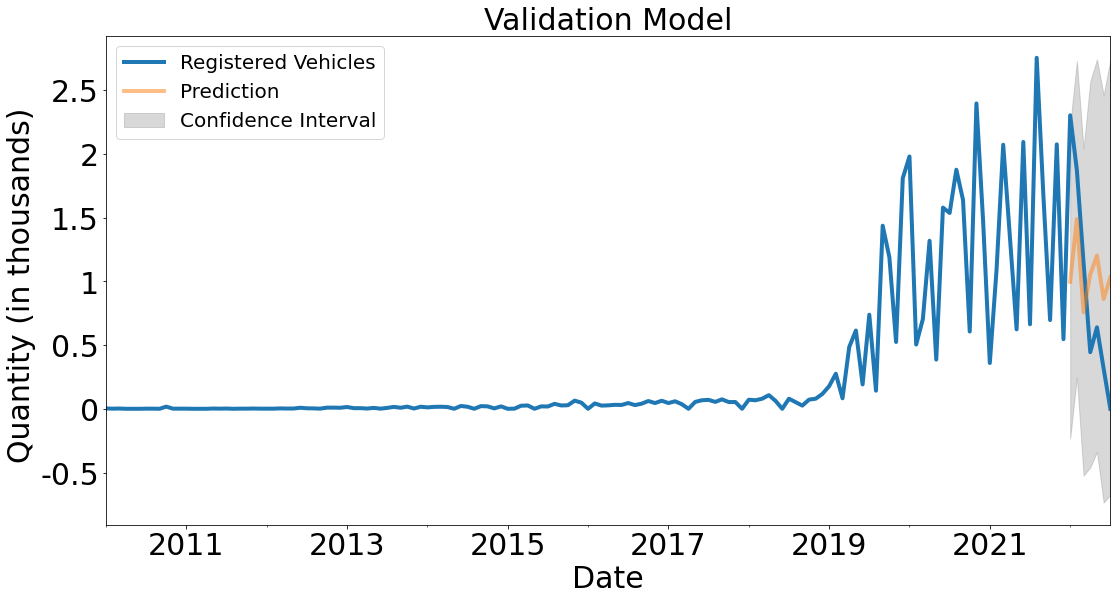

In [23]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()